In [1]:
import matplotlib.pyplot as plt
from os import listdir
import json
from os.path import isfile, isdir, join
import numpy as np
from typing import Callable, Union, Tuple, List, Dict
from collections import defaultdict
from matplotlib.axes import Axes
import matplotlib.patches as mpatches
from math import ceil

In [2]:
""" Common functions and variables
"""

base_dir = "approx-upf-server-traces/"
experiment_dirs = []
for file in listdir(base_dir):
    filepath = join(base_dir, file)
    if isdir(filepath):
        experiment_dirs.append(filepath)
        
experiment_dirs.sort()


colors = ["red", "green", "blue", "purple"]


labels = []
seen_labels = set()


def place_legend(ax: Axes):
    """ Place a legend for colors used across multiple lines/violins
    """
    global labels
    global seen_labels
    # Place the legend in the figure
    ax.legend(*zip(*labels), loc=2)
    # clear the legend entries for the next figure
    labels = []
    seen_labels = set()

    
def add_label_for_color(color, label):
    """ Create a legend entry for a color shared across multiple lines/plots/violins/etc
    """
    if label in seen_labels:
        return
    seen_labels.add(label)
    labels.append((mpatches.Patch(color=color), label))
    
    
def get_intervals_from_data(data):
    """ Grab list interval dictionaries from a iperf3 json
    """
    return list(data["intervals"])[1:-1]  # discard first and last intervals, only look at steady-state


def get_experiment_files(experiment_dir: str) -> List[Tuple[str, str]]:
    """ Returns list of (<filename minus extension>, <filepath>) pairs
    """
    experiment_files: List[Tuple[str, str]] = []
    for file in listdir(experiment_dir):
        filepath = join(experiment_dir, file)
        if isfile(filepath):
            if filepath.endswith(".json"):
                experiment_files.append((file[:-5], filepath))  # [:-5] strips the '.json'
    return experiment_files

No handles with labels found to put in legend.
No handles with labels found to put in legend.


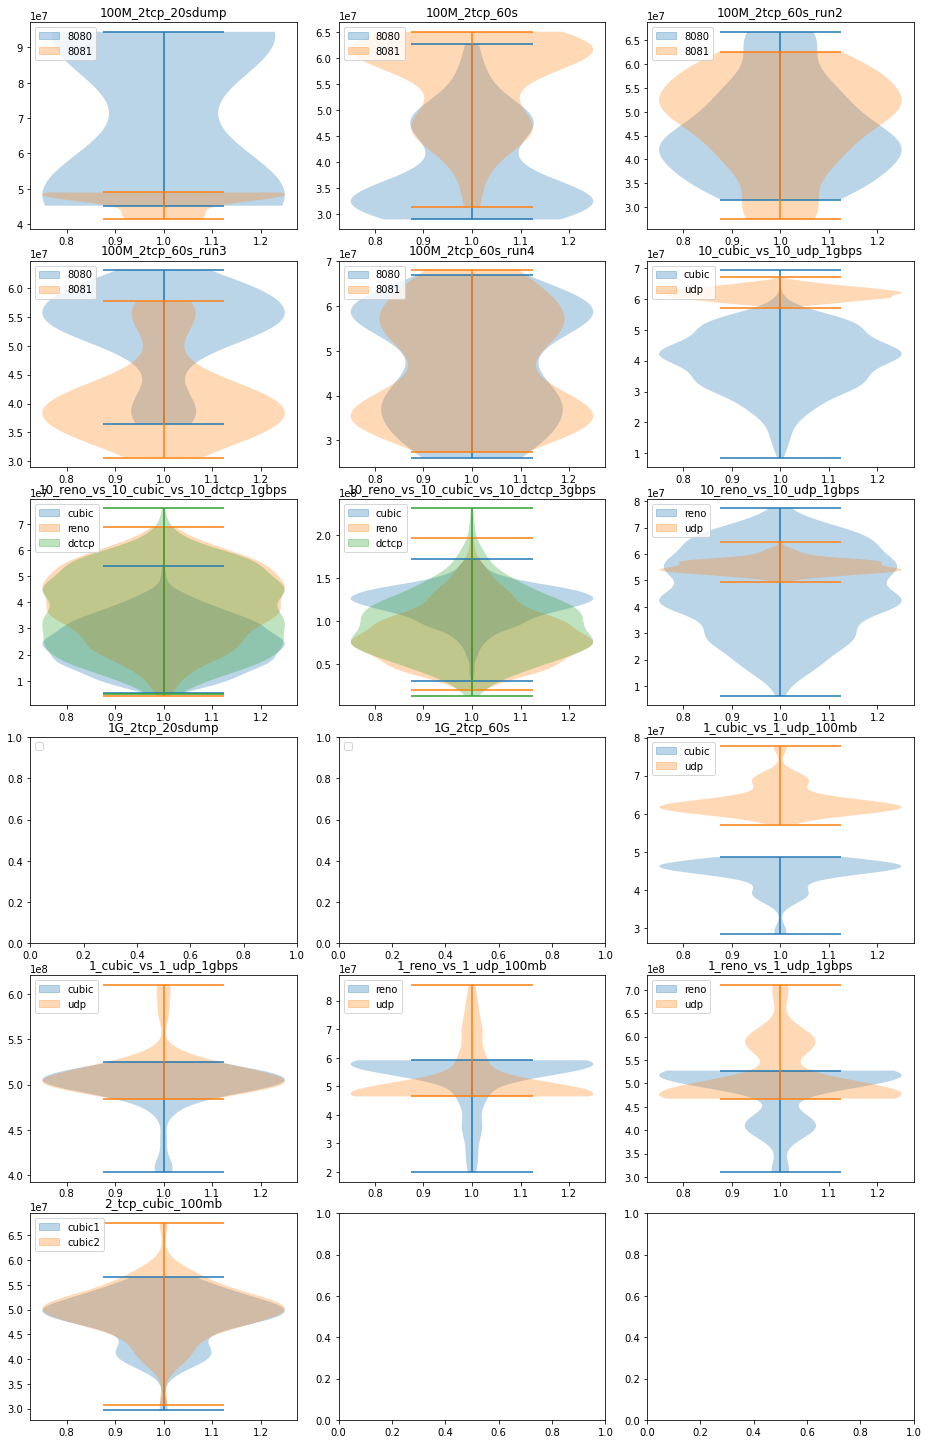

In [3]:
""" Per-L4 violin plots of all per-(stream,interval) bandwidth data points
"""


plt.rcParams['figure.figsize'] = [13, 20]
FIGURE_COLUMNS = 3

    
def color_of_violin(violin):
    """ Grab the color of a violin plot.
    """
    return violin["bodies"][0].get_facecolor().flatten()


def get_subexperiment_bandwidth_samples(subexp_json: str) -> List[float]:
    """ Return all bandwidth samples across all streams, merged into a single list.
    """
    with open(subexp_json, 'r') as fp:
        data = json.load(fp)
    all_flow_rates = []
    intervals = get_intervals_from_data(data)
    for interval in intervals:
        flow_rates = [stream["bits_per_second"] for stream in interval["streams"]]
        all_flow_rates.extend(flow_rates)
    return all_flow_rates


def plot_experiment_violin(experiment_dir: str, ax: Axes):
    """
    Plot a single violin representing the distribution of per-interval iperf bandwidth measurements.
    The per-interval measurements from every iperf3 socket will be merged into a single set.
    """
    global labels
    experiment_files = get_experiment_files(experiment_dir)
                
    for subexp_name, subexp_json in experiment_files:
        flow_rates = get_subexperiment_bandwidth_samples(subexp_json)
        color = color_of_violin(ax.violinplot([flow_rates]))
        add_label_for_color(color, subexp_name)
    title = experiment_dir.split("/")[-1]
    ax.set_title(title)
    place_legend(ax)


def plot_all_experiments_violin():
    """ 
    For every experiment directory, plot a set of distribution violins for every L4 file
    found in the directory.    
    """
    num_figs = len(experiment_dirs)
    cols = FIGURE_COLUMNS
    rows = ceil(num_figs / cols)
    

    fig, axes  = plt.subplots(rows, cols)
    fig.tight_layout()
    
    for i, experiment_dir in enumerate(experiment_dirs):
        plot_experiment_violin(experiment_dir, axes[i // cols, i % cols])
    plt.show()
    
    
plot_all_experiments_violin()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


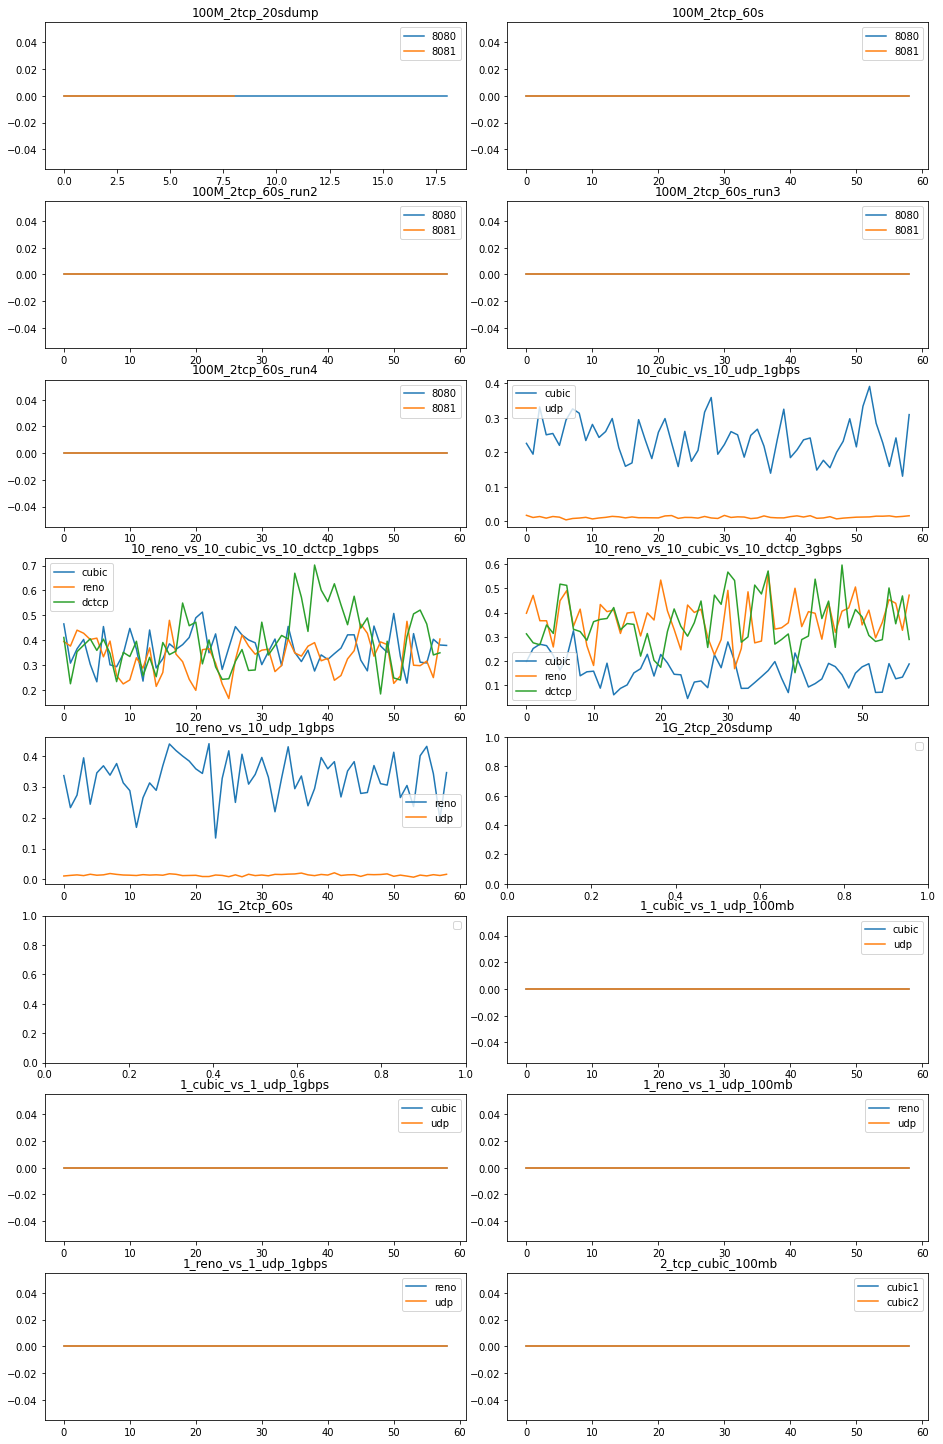

In [4]:
""" Per-L4 variance coefficient of all streams over time
"""


plt.rcParams['figure.figsize'] = [13, 20]
FIGURE_COLUMNS = 2


def get_subexperiment_variances(subexp_json: str) -> List[float]:
    """
    Get the per-interval variance coefficient of the set of bandwidths achieved across all sockets.
    Returns a list of length equal to the number of intervals.
    """
    with open(subexp_json, 'r') as fp:
        data = json.load(fp)

    intervals = get_intervals_from_data(data)
    interval_variance_coeffs = []
    for interval in intervals:
        flow_rates = [stream["bits_per_second"] for stream in interval["streams"]]
        variance_coefficient = np.std(flow_rates) / np.mean(flow_rates)
        interval_variance_coeffs.append(variance_coefficient)
    return interval_variance_coeffs


def plot_experiment_variance_coeff(experiment_dir: str, ax: Axes):
    """
    Plot a line of per-interval variance coefficients for each L4 iperf3 trace found
    in the experiment directory.
    """
    experiment_files = get_experiment_files(experiment_dir)

    for subexp_name, subexp_json in experiment_files:
        subexp_variance_coeffs = get_subexperiment_variances(subexp_json)
        ax.plot(list(range(len(subexp_variance_coeffs))), subexp_variance_coeffs, label=subexp_name)
    title = experiment_dir.split("/")[-1]
    ax.set_title(title)
    ax.legend()
    

def plot_all_experiment_variance_coeffs():
    """
    For every experiment directory, plot a set of variance coefficient lines for every L4 file
    found in the directory.
    This approach is invalid for single-socket pcap files and will yield flat lines.
    """
    num_figs = len(experiment_dirs)
    cols = FIGURE_COLUMNS
    rows = ceil(num_figs / cols)
    

    fig, axes  = plt.subplots(rows, cols)
    fig.tight_layout()
    
    for i, experiment_dir in enumerate(experiment_dirs):
        plot_experiment_variance_coeff(experiment_dir, axes[i // cols, i % cols])
    plt.show()


plot_all_experiment_variance_coeffs()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


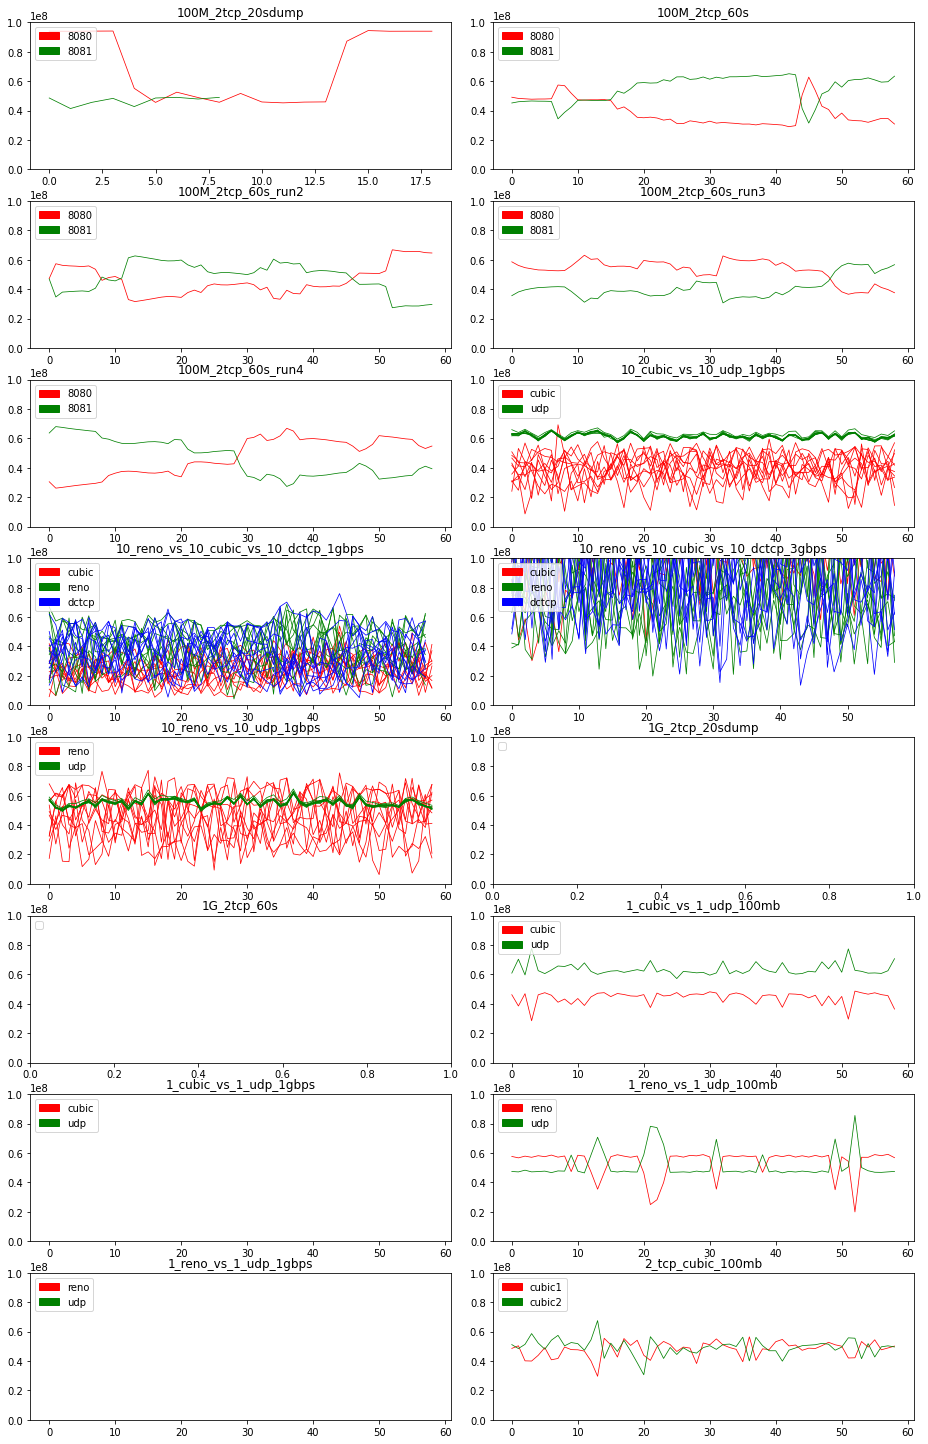

In [6]:
""" Per-(L4, stream) line plots of per-interval bandwidth data points
"""


plt.rcParams['figure.figsize'] = [13, 20]
FIGURE_COLUMNS = 2


def get_subexp_bandwidth_lines(subexp_json: str):
    """
    For a single iperf3 json file, get a list comprised of per-socket lists of bandwidth measurements.
    """
    with open(subexp_json, 'r') as fp:
        data = json.load(fp)
    intervals = get_intervals_from_data(data)
    # a list for every iperf connection
    stream_rates = {stream["socket"]:[] for stream in intervals[0]["streams"]}
    for interval in intervals:
        for stream in interval["streams"]:
            stream_rates[stream["socket"]].append(stream["bits_per_second"])
    return list(stream_rates.values())  # discard socket IDs


        
def plot_bandwidth_lines(experiment_dir: str, ax: Axes):
    """
    For an experiment containing several iperf3 json files, plot the bandwidth over time of each
    socket stream found in each json. Each line will be labeled with the name of the json.
    """
    global labels
    experiment_files = get_experiment_files(experiment_dir)

    for i, (subexp_name, subexp_json) in enumerate(experiment_files):
        bandwidth_lines = get_subexp_bandwidth_lines(subexp_json)
        for points in bandwidth_lines:
            ax.plot(list(range(len(points))), points, color=colors[i], linewidth=0.75)
            add_label_for_color(colors[i], subexp_name)
    title = experiment_dir.split("/")[-1]
    ax.set_title(title)
    ax.set_ylim((0, 1e8))
    place_legend(ax)

    
def plot_all_experiments_lines():
    """
    For each experiment directory, plot a figure containing the bandwidth lines of all the iperf3 socket
    streams found in the directory.
    """
    num_figs = len(experiment_dirs)
    cols = FIGURE_COLUMNS
    rows = ceil(num_figs / cols)
    

    fig, axes  = plt.subplots(rows, cols)
    fig.tight_layout()
    
    for i, experiment_dir in enumerate(experiment_dirs):
        plot_bandwidth_lines(experiment_dir, axes[i // cols, i % cols])
    plt.show()


plot_all_experiments_lines()